# Fundamentals-of-Neural-Networks
This project is part of the 5LSH0 - Computer Vision AI and 3D Data Analysis course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Variables explanation
- **W1**: Weights for the first layer (input to hidden layer)
- **b1**: Bias for the first layer
- **W2**: Weights for the second layer (hidden to output layer)
- **b2**: Bias for the second layer
- **A1**: Activation of the first layer (output after applying activation function to Z1)
- **A2**: Output of the network (after applying softmax activation function to Z2)
- **Z1**: Linear transformation for the first layer (W1.dot(values) + b1)
- **Z2**: Linear transformation for the second layer (W2.dot(A1) + b2)
- **m**: Number of training examples (samples in the training set)
- **n**: Number of features (including labels)
- **values**: Input features (e.g., pixel values for MNIST images)
- **labels**: Ground truth labels (e.g., corresponding digit labels for MNIST images)
- **dW1**: Gradient of the weights for the first layer
- **db1**: Gradient of the bias for the first layer
- **dW2**: Gradient of the weights for the second layer
- **db2**: Gradient of the bias for the second layer
- **alpha**: Learning rate (step size for weight updates)

### Example outcome

gradient descen iterations 500,  alpha 0.1,  sigmoid - traininig 10min, accuracy 0.7, loss 1.16
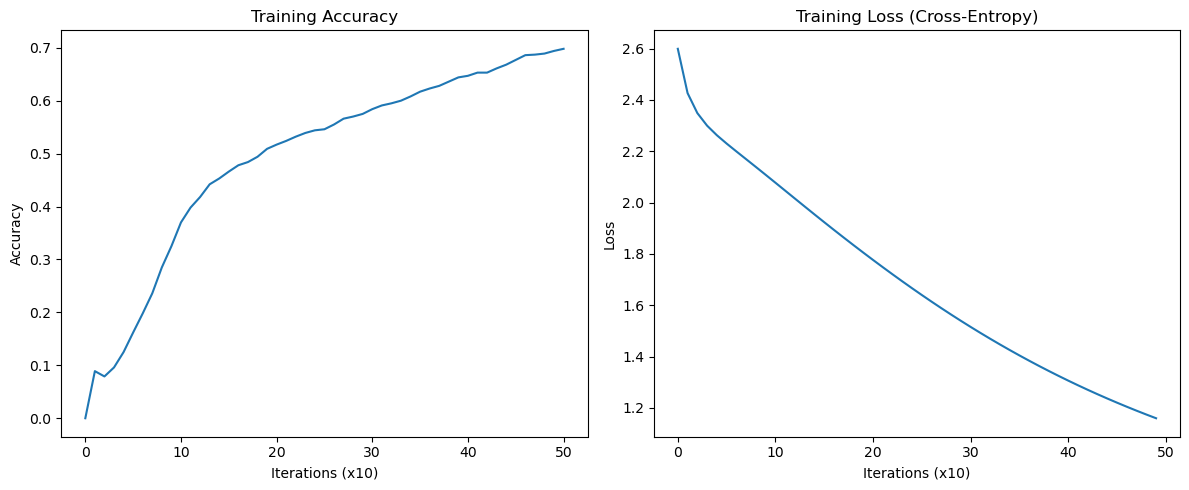

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [68]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
ALPHA = 0.1
ITERATIONS = 2000
TRAININIG_UPDATES = 10 #number of iterations after which trainiing update is printed
TRAINING_SHOW_UPDATES = 100 #number of iterations after which trainiing plot is shown

In [69]:
def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [70]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (69000,)
values_train.shape = (784, 69000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


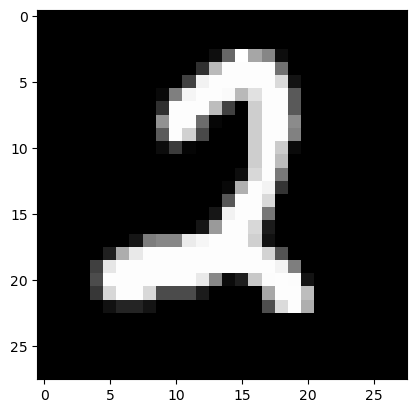

In [71]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[TEST_SIZE:m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [72]:
def init_params():
    """Initialize NN weights and biases"""
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels):
    """Perform one hot encoding returning a binary matrix based on provided labels"""
    # Class 0 -> [1,0,0,...]
    # Class 1 -> [0,1,0,...]
    # ...

    one_hot_labels = np.zeros((labels.size, labels.max() + 1))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels.T

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0

def deriv_sigmoid(Z):
    """Calculate derivative of sigmoid activation function"""
    return sigmoid(Z) * (1 - sigmoid(Z))
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, 1)

    # Calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / m * dZ1.dot(values.T)
    db1 = 1 / m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [73]:
def cross_entropy_loss(A2, one_hot_labels):
    """
    Calculate cross-entropy loss
    A2: predicted probabilities from softmax (shape: [num_classes, batch_size])
    one_hot_labels: one-hot encoded true labels (shape: [num_classes, batch_size])
    """

    log_probs = np.log(A2)

    # Calculate the loss for each example: sum of true labels * log(probabilities)
    loss_sample = -np.sum(one_hot_labels * log_probs, axis=0)

    loss = np.mean(loss_sample)
    
    return loss

In [74]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def gradient_descent(values_train, labels_train, iterations, alpha, values_validation, labels_validation ):
    """Create a 3 layer NN and train it using gradient descent method"""
    start_time = time.time()
    
    W1, b1, W2, b2 = init_params()
    accuracy_validation_history = [0]
    accuracy_train_history = [0]
    loss_validation_history = []
    loss_train_history = []
    for i in range(iterations):
        
        # NN training 
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, values_train)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, values_train, labels_train)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Training pogress 
        if i % TRAININIG_UPDATES == 0:
            print("Iteration:", i)

            # make predictions and test accuracy using train set
            predictions_train = make_predictions(values_train, W1, b1, W2, b2)
            accuracy_train = get_accuracy(predictions_train, labels_train)
            loss_train = cross_entropy_loss(A2, one_hot(labels_train))

            # make predictions and test accuracy using validation set
            _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values_validation)
            predictions_validation = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy_validation = get_accuracy(predictions_validation, labels_validation)
            loss_validation = cross_entropy_loss(A2, one_hot(labels_validation))

            # store values
            accuracy_train_history.append(accuracy_train)
            accuracy_validation_history.append(accuracy_validation)
            loss_train_history.append(loss_train)
            loss_validation_history.append(loss_validation)

            if i % TRAINING_SHOW_UPDATES == 0:
                # present traininig progress
                print(f"Train Accuracy: {accuracy_train:.3f}")
                print(f"Validation Accuracy: {accuracy_validation:.3f}")
                print(f"Train Loss: {loss_train:.3f}")
                print(f"Validation Loss: {loss_validation:.3f}")
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

                ax[0].plot(accuracy_train_history, label="Train Accuracy")
                ax[0].plot(accuracy_validation_history, label="Validation Accuracy")
                ax[0].set_title("Training Accuracy")
                ax[0].set_xlabel(f"Iterations (x{TRAININIG_UPDATES})")
                ax[0].set_ylabel("Accuracy")
                ax[0].legend()

                ax[1].plot(loss_train_history, label="Train Loss")
                ax[1].plot(loss_validation_history, label="Train Loss")
                ax[1].set_title("Training Loss")
                ax[1].set_xlabel(f"Iterations (x{TRAININIG_UPDATES})")
                ax[1].set_ylabel("Loss")
                ax[1].legend()

                plt.tight_layout()
                plt.show()

    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")
    
    return W1, b1, W2, b2

Iteration: 0
Train Accuracy: 0.124
Validation Accuracy: 0.115
Train Loss: 2.870
Validation Loss: 2.782


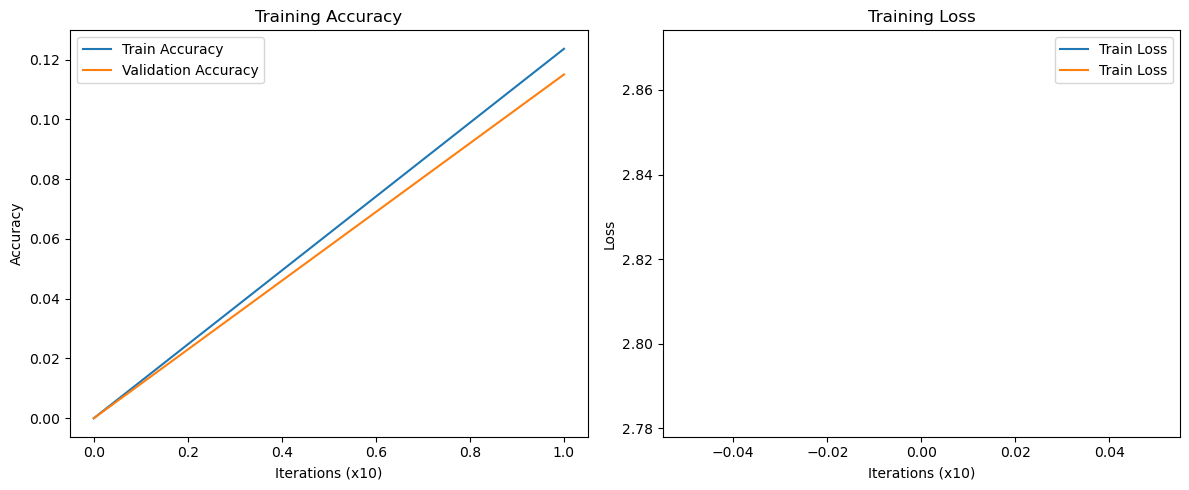

Iteration: 10
Iteration: 20


In [75]:
# Perform NN training
W1, b1, W2, b2 = gradient_descent(values_train, labels_train, ITERATIONS, ALPHA, values_validation, labels_validation)


In [ ]:
def evaluate_model(W1, b1, W2, b2, values, labels):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, labels)
    loss = cross_entropy_loss(A2, one_hot(labels))

    return accuracy, loss

print(evaluate_model(W1, b1, W2, b2, values_test, labels_test))

(0.876, 0.39218880317533544)
